In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )
print(gammapy)

loaded gammapy version: 1.0 
Supposed to be 1.0 (21-12-2022)
<module 'gammapy' from 'C:\\Users\\Ludwig\\miniconda3\\envs\\gammapy-1.0-irf\\lib\\site-packages\\gammapy\\__init__.py'>


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset, Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset


## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 1MUXqVCD 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361088.27
  Predicted background counts     : 360331.34
  Predicted excess counts         : 756.93

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.77

  Number of models                : 2 
  Number of parameters            : 13
  Number of free parameters       : 8

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal mo

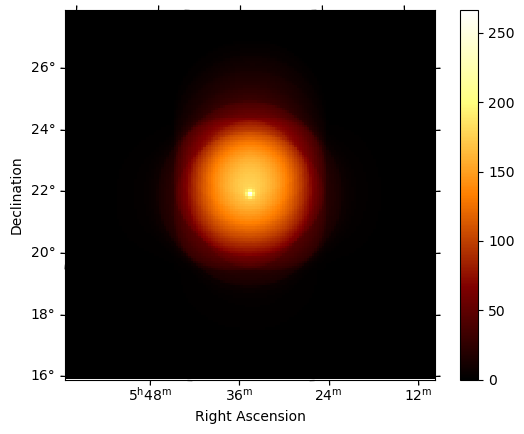

In [3]:
dataset_asimov = MapDataset.read("c:/users/yt02izug/downloads/dataset_asimov/dataset_asimov.fits")
# Create the spatial model 
model_spatial = GaussianSpatialModel(
    lon_0="83.631 deg",
    lat_0="22.018 deg",
    sigma="0.02 deg",
    )

# Create the spectral model 
model_spectrum  = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",
    lambda_="0.1 TeV-1")

# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = model_spatial ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)

# set the models in the dataset
dataset_asimov.models = models
# set counts
dataset_asimov.counts = dataset_asimov.npred()
    
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_asimov.geoms["geom"].width[1] / dataset_asimov.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_asimov)

## Asimov Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value

# energy independent method: pm 10%
shift_neg = -0.1#-0.085
shift_pos = 0.1#+0.085
shift_cor = 0.0

tilt_neg = -0.015 # 1e-24 for computational purposes -> covmatrix "1/0"
tilt_pos = 0.015
tilt_cor = 0.

print(tilt_neg)

-0.015


In [5]:
sys_d_cor = sys_dataset(dataset_asimov, shift_cor, tilt_cor, False)
dataset_cor_N = sys_d_cor.create_dataset_N()

sys_d_neg = sys_dataset(dataset_asimov, shift_neg, tilt_neg, False)
dataset_neg_N = sys_d_neg.create_dataset_N()

sys_d_pos = sys_dataset(dataset_asimov, shift_pos, tilt_pos, False)
dataset_pos_N = sys_d_pos.create_dataset_N()

zero = 1e-24
## additional parameter bias and resolution (ereco) but are frozen
#penalising_invcovmatrix = np.zeros((4, 4))
#np.fill_diagonal(penalising_invcovmatrix,
 #                [1/(shift_neg*1)**2, 1/(tilt_neg*1)**2, 1/zero**2, 1/zero**2])
penalising_invcovmatrix = [[1/shift_neg**2, 1/(shift_neg*tilt_neg*100), 0, 0], 
                           [1/(shift_neg*tilt_neg*100), 1/tilt_neg**2, 0, 0], 
                           [0, 0, 1/zero**2, 0], 
                           [0, 0, 0, 1/zero**2]]
dataset_pos_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_cor_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_neg_N.penalising_invcovmatrix = penalising_invcovmatrix

datasets  = [dataset_pos_N, dataset_cor_N, dataset_neg_N]

print(datasets[1])

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361088 
  Total background counts         : 360331.31
  Total excess counts             : 756.96

  Predicted counts                : 361086.89
  Predicted background counts     : 360331.34
  Predicted excess counts         : 755.55

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -752490.76

  Number of models                : 3 
  Number of parameters            : 18
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Paramet

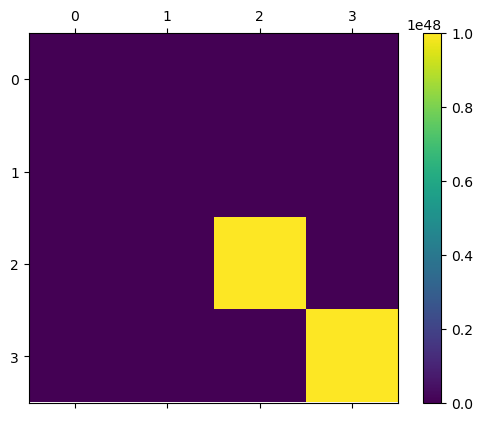

In [6]:
fig, ax = plt.subplots(1,1)
#ax = fig.add_subplot(111)
cax = ax.matshow(penalising_invcovmatrix)  # interpolation='nearest')
fig.colorbar(cax);
#cax = ax[1].matshow(penalising_invcovmatrix)  # interpolation='nearest')
#fig.colorbar(cax);

corr
neg
pos
CPU times: total: 1h 39min 29s
Wall time: 16min 47s


<AxesSubplot: >

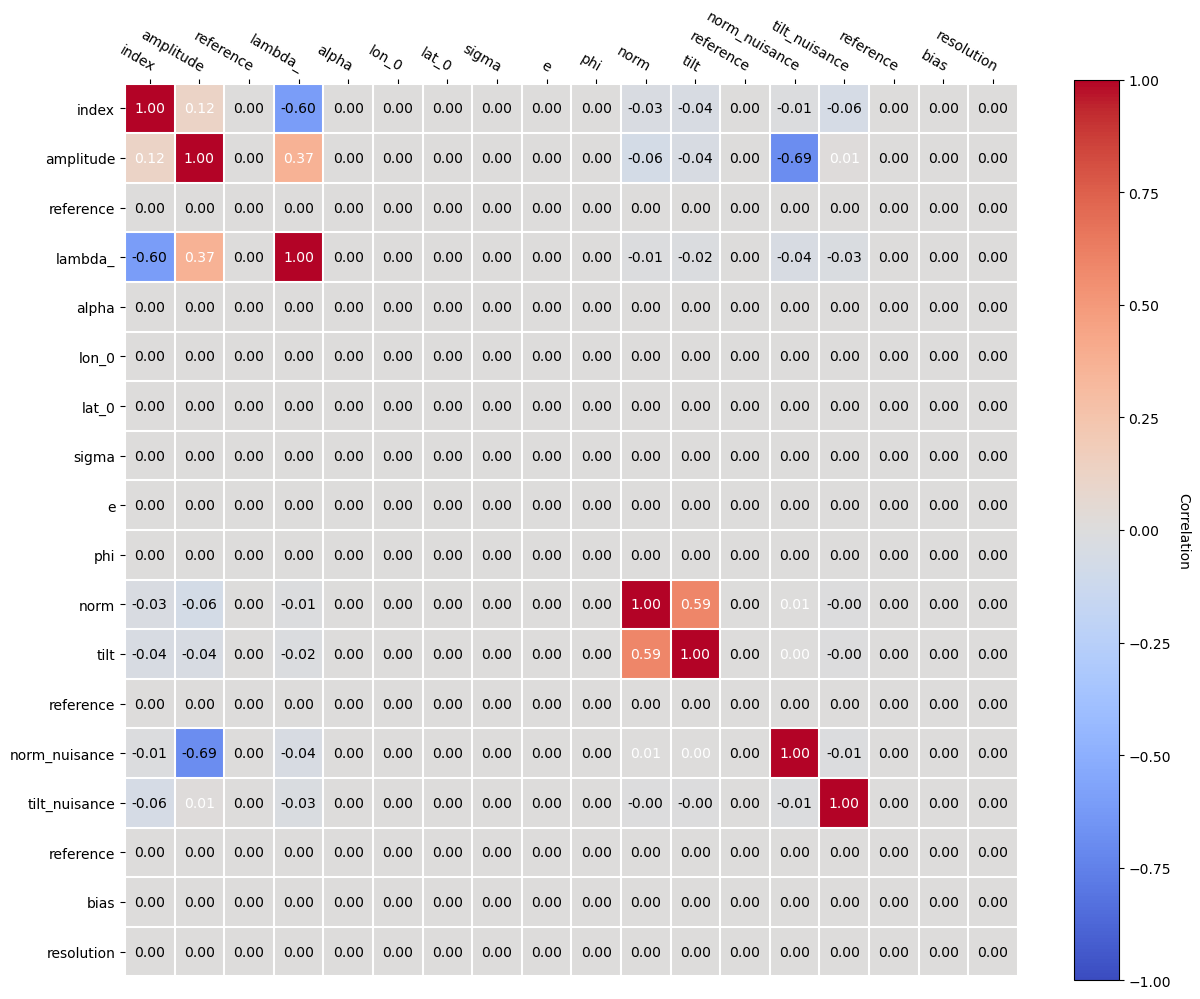

In [7]:
%%time
print("corr")
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.backend = "minuit"
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run(dataset_cor_N)
        
print("neg")
fit_neg = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_neg.backend = "minuit"
fit_neg.optimize_opts = minuit_opts
result_neg = fit_neg.run(dataset_neg_N)

print("pos")
fit_pos = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_pos.backend = "minuit"
fit_pos.optimize_opts = minuit_opts
result_pos = fit_pos.run(dataset_pos_N)

dataset_cor_N.models.covariance = fit_cor.covariance(dataset_cor_N).matrix
dataset_cor_N.models.covariance.plot_correlation()

#dataset_neg_N.models.covariance = fit_neg.covariance(dataset_neg_N).matrix
#dataset_neg_N.models.covariance.plot_correlation()

#dataset_pos_N.models.covariance = fit_pos.covariance(dataset_pos_N).matrix
#dataset_pos_N.models.covariance.plot_correlation()

In [8]:
datasets_short = [dataset_neg_N, dataset_cor_N, dataset_pos_N]
print("best fit amplitude")
amplitudes_N = []
m = dataset_asimov.models[0]
value = m.parameters['amplitude'].value 
error = m.parameters['amplitude'].error
amplitudes_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['amplitude'].value 
    error = m.parameters['amplitude'].error
    amplitudes_N.append((value, error))
    print(f'{value} pm {error}')
print()
print("best fit Index")
indices_N = []
m = dataset_asimov.models[0]
value = m.parameters['index'].value 
error = m.parameters['index'].error
indices_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    m = d.models[0]
    value = m.parameters['index'].value 
    error = m.parameters['index'].error
    indices_N.append((value, error))
    print(f'{value} pm {error}')
print()

print("Best Fit bkg Norm")
norms_N = []
value = dataset_asimov.background_model.parameters['norm'].value 
error = dataset_asimov.background_model.parameters['norm'].error
norms_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.background_model.parameters['norm'].value 
    error = d.background_model.parameters['norm'].error
    print(f'{value} pm {error}')
    norms_N.append((value, error))
print()   
    
print("Best Fit Lambda Norm")
lambdas_N = []
value = dataset_asimov.models.parameters['lambda_'].value 
error = dataset_asimov.models.parameters['lambda_'].error
lambdas_N.append((value, error))
print('====')
print('Input')
print(f'{value} pm {error}')
print('====')
for d in datasets_short:
    value = d.models.parameters['lambda_'].value 
    error = d.models.parameters['lambda_'].error
    print(f'{value} pm {error}')
    lambdas_N.append((value, error))

best fit amplitude
====
Input
1e-12 pm 0
====
1.1141996180684381e-12 pm 1.8982402391279381e-13
1.0028079776799132e-12 pm 1.7079802208706657e-13
9.112823907613198e-13 pm 1.5517057277100898e-13

best fit Index
====
Input
2.3 pm 0
====
2.3229878330579474 pm 0.15797169018782078
2.3086873127743615 pm 0.1579277930517229
2.2942632342898426 pm 0.15766597857863474

Best Fit bkg Norm
====
Input
1.0 pm 0
====
1.0000006675798803 pm 0.002066553701198106
1.0000008250422148 pm 0.0020665533032518035
1.0000014719845352 pm 0.00206655709361837

Best Fit Lambda Norm
====
Input
0.1 pm 0
====
0.09877516104327691 pm 0.04741510253882298
0.09855897477174907 pm 0.047368828447631635
0.09829728416875916 pm 0.04722214255260012


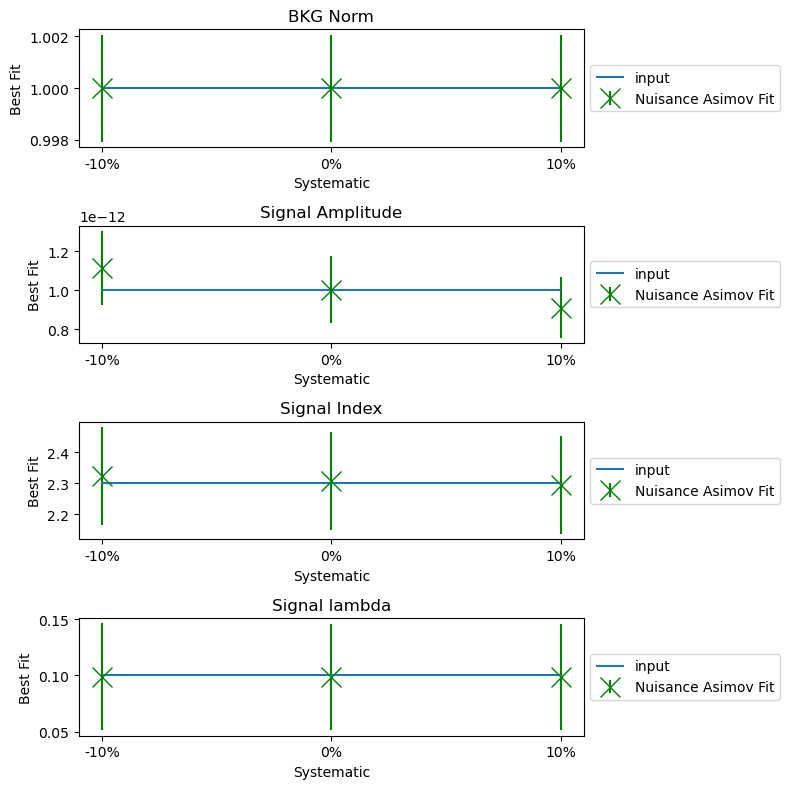

In [9]:
fig, axs = plt.subplots(4,1, figsize=(8,8))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal lambda")


labels_sys = ['-10%', '0%', '10%']
label = "Nuisance Asimov Fit"

for i, a in enumerate(norms_N[1:]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[0].hlines( norms_N[0][0], 1, 3, label = "input")

for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[1].hlines( amplitudes_N[0][0], 1, 3, label = "input")

for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices_N[0][0], 1, 3, label = "input")

for i, a in enumerate(lambdas_N[1:]):
    axs[3].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[3].hlines(lambdas_N[0][0], 1, 3, label = "input")

plt.tight_layout()
for a in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    a.legend(by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1, 0.5))
    a.set_ylabel('Best Fit'); 
    a.set_xlabel('Systematic'); 
    a.set_xticks(np.arange(3)+1,labels_sys)

plt.tight_layout()    
fig.savefig("best_fit_parameters_corr.pdf")   


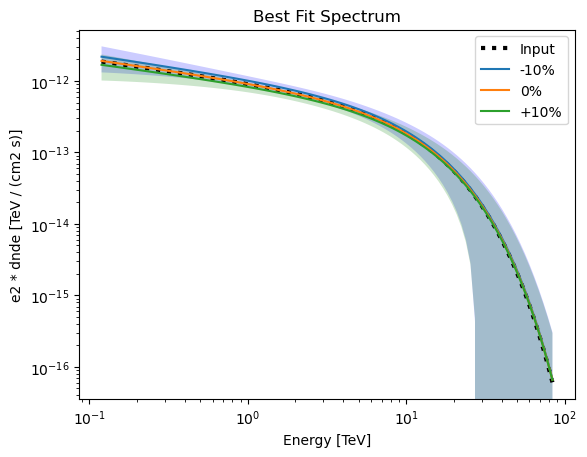

In [10]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value


fig,ax = plt.subplots()
energy_bounds = energy_bounds =(true_energy[0], true_energy[-1] ) * u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                               label = "Input", color = 'black', linewidth = 3, linestyle ='dotted')

dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "-10%")
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                       facecolor='blue')

dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "0%")
                                   
#dataset_cor_N.models['Source'].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
#                                                       facecolor='orange')


                               
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = ax,
                                label = "+10%")
dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = ax,
                                                        facecolor = 'green')


plt.legend()

plt.title("Best Fit Spectrum")
fig = plt.gcf()
#fig.savefig("plots/2_spectrum.pdf")

In [11]:
#print(dataset_asimov)

2.4190464144492064e-05 0.10745369532752902
-5.583815738407584e-06 0.10744523932353306
0.0005114018293197286 0.10748839800669702
-1.2507076582796205e-05 0.01497876897875417
-9.467805815796777e-06 0.014978757500531759
-1.14085978057042e-05 0.014978738805552382
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


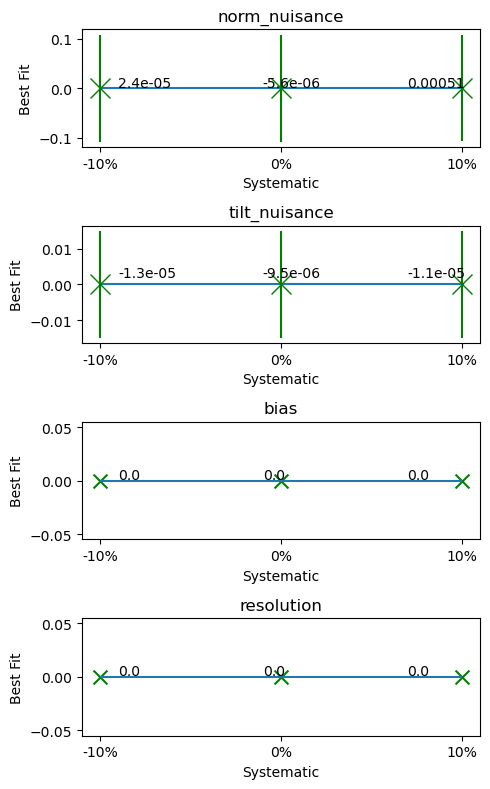

In [12]:
n_nui = len(dataset_neg_N.models.parameters.penalised_parameters)
fig, a  = plt.subplots(n_nui, 1, figsize = (5,2* n_nui))
if n_nui ==1:
    a = [a]
label = 'Nuisance Fit'
iss = [1.1, 1.9, 2.7]
for j, par_name in enumerate(dataset_neg_N.models.parameters.penalised_parameters.names):
    for i, d in enumerate([dataset_neg_N, dataset_cor_N, dataset_pos_N]):
        value = d.models.parameters[par_name].value
        error = d.models.parameters[par_name].error
        print(value, error)
        if error > 1e-24:
            a[j].errorbar(x= i+1, y = value, yerr = error, fmt= 'x', color = 'green', markersize=14,
                       label = label)
        else:
            a[j].scatter(i+1, value, color = 'green', marker = 'x', s=100,
                       label = label)
        a[j].text(iss[i],0.002, f'{value:.2}', )
    a[j].hlines( 0., 1, 3, label = "input")
    
    a[j].set_ylabel('Best Fit' ); 
    a[j].set_title(par_name)
    a[j].set_xlabel('Systematic'); 
    a[j].set_xticks(np.arange(3)+1,labels_sys);

plt.tight_layout()
#fig.savefig("plots/2_best_fit_nui.pdf")

## Comparison

In [13]:

with open('data/1_norms.yaml') as file:
    norms = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_amplitudes.yaml') as file:
    amplitudes = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_indices.yaml') as file:
    indices = yaml.load( file, Loader=yaml.FullLoader)
with open('data/1_lambdas.yaml') as file:
    lambdas = yaml.load( file, Loader=yaml.FullLoader)


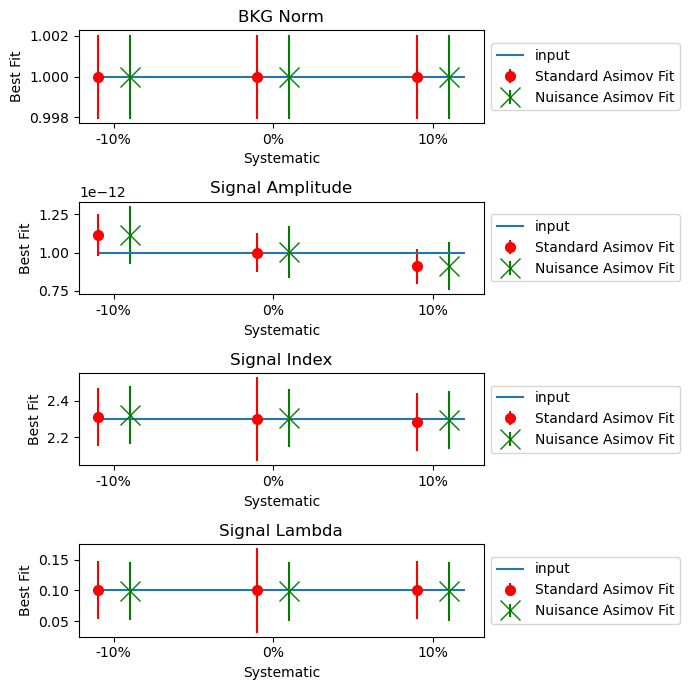

In [14]:
fig, axs = plt.subplots(4,1, figsize= (7, 7))

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")
axs[3].set_title("Signal Lambda")


labels_sys = [ '-10%', '0%', '10%']

for i, a in enumerate(norms[1:]):
    label = "Standard Asimov Fit"
    axs[0].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(amplitudes[1:]):
    axs[1].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(indices[1:]):
    axs[2].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
for i, a in enumerate(lambdas[1:]):
    axs[3].errorbar(x= i+0.9, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize = 7,
                   label = label)
    
for i, a in enumerate(norms_N[1:]):
    label = "Nuisance Asimov Fit"
    axs[0].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(amplitudes_N[1:]):
    axs[1].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(indices_N[1:]):
    axs[2].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
for i, a in enumerate(lambdas_N[1:]):
    axs[3].errorbar(x= i+1.1, y = a[0], yerr = a[1], fmt= 'x', color =  'green',markersize=14,
                   label = label)
axs[2].hlines( indices[0][0], 0.91, 3.2, label = "input")
axs[0].hlines( norms[0][0], 0.91, 3.2, label = "input")
axs[1].hlines( amplitudes[0][0], 0.91, 3.2, label = "input")
axs[3].hlines( lambdas[0][0], 0.91, 3.2, label = "input")

plt.tight_layout()
for ax in axs:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Best Fit'); 
    ax.set_xlabel('Systematic'); 
    ax.set_xticks(np.arange(3)+1,labels_sys)

    
#axs[0].set_ylim(0.85, 1.15)
plt.tight_layout()    
fig.savefig("plots/2_best_fit_parameters_comparison.pdf")   


### Spectrum

In [15]:
dataset_st_neg = dataset_neg_N.copy()
dataset_st_neg.models = Models.read("data/1_model_neg.yml")

dataset_st_pos = dataset_pos_N.copy()
dataset_st_pos.models = Models.read("data/1_model_pos.yml")

dataset_st_cor = dataset_cor_N.copy()
dataset_st_cor.models = Models.read("data/1_model_cor.yml")

In [16]:
for d in datasets:
    for p in d.models.parameters.penalised_parameters:
        p.frozen = True

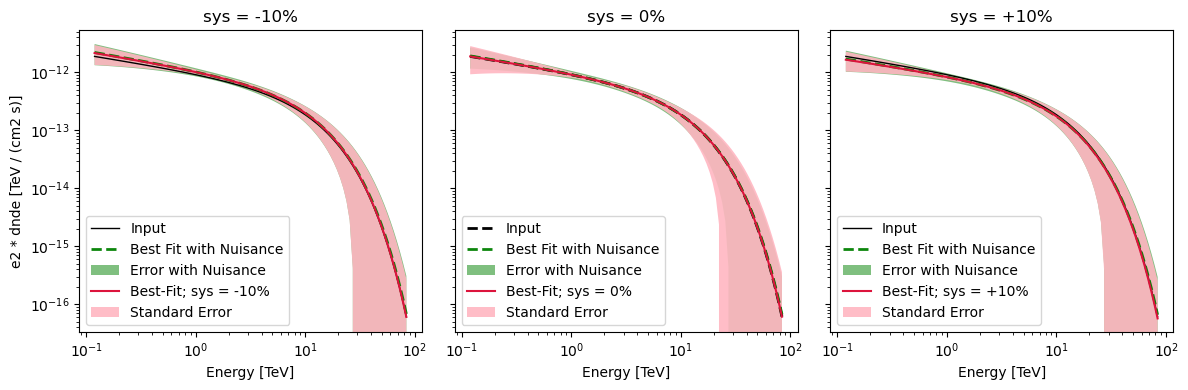

In [17]:
true_energy = dataset_cor_N.exposure.geom.axes[0].center.value
energy_bounds = (true_energy[0], true_energy[-1] ) * u.TeV
fig,axs = plt.subplots(1,3, sharey=True,figsize = (12,4))

for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )


dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       color='green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)        
dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[0],
                                label = "Best-Fit; sys = -10%", color = "crimson")
dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[0],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### cor 
dataset_cor_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],color = 'green',
                                                         label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_cor_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_cor.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[1],
                                label = "Best-Fit; sys = 0%", color = "crimson")
dataset_st_cor.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[1],
                                                       facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
### pos 
dataset_pos_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],color = 'green',
                                                               label="Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)                                              

dataset_pos_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                       facecolor='green',
                                                         label="Error with Nuisance",
                                                        alpha = 0.5)
dataset_st_pos.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[2],
                                label = "Best-Fit; sys = +10%", color = "crimson")
dataset_st_pos.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[2],
                                                      facecolor='lightpink',
                                                          alpha = 0.9,
                                                          label= "Standard Error"
                                                         )
[a.legend() for a in axs]
axs[0].set_title("sys = -10%"); axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 

axs[1].set_ylabel('')
axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("plots/2_spectrum_comparison.pdf")